In [2]:
import numpy as np

train_data = np.load("/kaggle/input/2024-1-1/train.npy", allow_pickle = "TRUE")
test_data = np.load("/kaggle/input/2024-1-1/test.npy", allow_pickle = "TRUE")

In [3]:
train_data_input = train_data.item().get('input')
train_data_label = train_data.item().get('label')

test_data_input = test_data.item().get('input')

In [4]:
train_input = train_data_input.squeeze()
test_input = test_data_input.squeeze()
print(train_input.shape)
print(test_input.shape)

(4608, 22, 1125)
(576, 22, 1125)


### Bandpass Filter 적용

In [5]:
import scipy.signal as signal

# Band-pass filter 설정
lowcut = 0.1
highcut = 30.0
fs = 250.0

def butter_bandpass(lowcut, highcut, fs, order = 5):
    nyquist = 0.5*fs
    low = lowcut/nyquist
    high = highcut/nyquist
    b, a = signal.butter(order, [low, high], btype = 'band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order = 5):
    b, a = butter_bandpass(lowcut, highcut, fs, order = order)
    y = signal.filtfilt(b, a, data, axis = -1)
    return y

In [6]:
train_input_filtered = np.zeros_like(train_input)
for i in range(train_input.shape[0]):
    for j in range(train_input.shape[1]):
        train_input_filtered[i, j, :] = bandpass_filter(train_input[i, j, :], lowcut, highcut, fs)

test_input_filtered = np.zeros_like(test_input)
for i in range(test_input.shape[0]):
    for j in range(test_input.shape[1]):
        test_input_filtered[i, j, :] = bandpass_filter(test_input[i, j, :], lowcut, highcut, fs)

In [7]:
print(f'Train input filtered shape: {train_input_filtered.shape}')
print(f'Test input filtered shape: {test_input_filtered.shape}')

Train input filtered shape: (4608, 22, 1125)
Test input filtered shape: (576, 22, 1125)


## STFT 적용

In [8]:
def compute_stft(data, fs, window='hann', nperseg=256, noverlap=128):
    f, t, Zxx = signal.stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, axis=-1)
    return f, t, Zxx

In [9]:
# STFT에 사용할 파라미터 설정
fs = 250  # 샘플링 주파수
nperseg = 256  # 각 세그먼트의 길이
noverlap = 128  # 세그먼트 간의 오버랩

# 샘플 데이터에 대해 STFT 계산을 통해 시간축 길이 결정
_, _, Zxx_sample = compute_stft(train_input_filtered[0, 0, :], fs, nperseg=nperseg, noverlap=noverlap)
time_length = Zxx_sample.shape[-1]

# STFT 결과를 저장할 배열 생성
train_stft = np.zeros((train_input_filtered.shape[0], train_input_filtered.shape[1], nperseg // 2 + 1, time_length))

for i in range(train_input_filtered.shape[0]):
    for j in range(train_input_filtered.shape[1]):
        f, t, Zxx = compute_stft(train_input_filtered[i, j, :], fs, nperseg=nperseg, noverlap=noverlap)
        train_stft[i, j, :, :] = np.abs(Zxx)

# test 데이터에 STFT 적용
test_stft = np.zeros((test_input_filtered.shape[0], test_input_filtered.shape[1], nperseg // 2 + 1, time_length))

for i in range(test_input_filtered.shape[0]):
    for j in range(test_input_filtered.shape[1]):
        f, t, Zxx = compute_stft(test_input_filtered[i, j, :], fs, nperseg=nperseg, noverlap=noverlap)
        test_stft[i, j, :, :] = np.abs(Zxx)


In [10]:
print(train_stft.shape)
print(test_stft.shape)

(4608, 22, 129, 10)
(576, 22, 129, 10)


### STFT

In [17]:
import numpy as np
import scipy.signal as signal
from mne.decoding import CSP
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE


In [22]:
def apply_stft(data, fs=250, nperseg=256, noverlap=128):
    num_samples, num_channels, _ = data.shape
    stft_real = []
    stft_imag = []

    for i in range(num_samples):
        sample_stft_real = []
        sample_stft_imag = []
        for j in range(num_channels):
            f, t, Zxx = signal.stft(data[i, j, :], fs, nperseg=nperseg, noverlap=noverlap)
            sample_stft_real.append(np.real(Zxx))
            sample_stft_imag.append(np.imag(Zxx))
        stft_real.append(np.array(sample_stft_real))
        stft_imag.append(np.array(sample_stft_imag))

    stft_real = np.array(stft_real)
    stft_imag = np.array(stft_imag)
    return stft_real, stft_imag

# STFT 적용
train_stft_real, train_stft_imag = apply_stft(train_input_filtered)
test_stft_real, test_stft_imag = apply_stft(test_input_filtered)

# 특정 주파수 대역 선택 (예: 8-12 Hz)
freq_band = (8, 12)
freq_indices = np.where((f >= freq_band[0]) & (f <= freq_band[1]))[0]

# 주파수 대역의 평균 값 계산
train_real_band_averaged = np.mean(train_stft_real[:, :, freq_indices, :], axis=2)
train_imag_band_averaged = np.mean(train_stft_imag[:, :, freq_indices, :], axis=2)
test_real_band_averaged = np.mean(test_stft_real[:, :, freq_indices, :], axis=2)
test_imag_band_averaged = np.mean(test_stft_imag[:, :, freq_indices, :], axis=2)

# 실수부와 허수부를 채널 축으로 연결
train_stft_band_averaged = np.concatenate([train_real_band_averaged, train_imag_band_averaged], axis=1)
test_stft_band_averaged = np.concatenate([test_real_band_averaged, test_imag_band_averaged], axis=1)


### CSP

In [13]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP

In [23]:
# 데이터와 라벨 준비
X_train = train_stft_band_averaged
y_train = np.argmax(train_data_label, axis=1)
X_test = test_stft_band_averaged

# CSP 적용
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

# 데이터를 2차원으로 변환
X_train_csp_flat = X_train_csp.reshape(X_train_csp.shape[0], -1)
X_test_csp_flat = X_test_csp.reshape(X_test_csp.shape[0], -1)


Computing rank from data with rank=None
    Using tolerance 0.98 (2.2e-16 eps * 44 dim * 1e+14  max singular value)
    Estimated rank (mag): 44
    MAG: rank 44 computed from 44 data channels with 0 projectors
Reducing data rank from 44 -> 44
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.98 (2.2e-16 eps * 44 dim * 1e+14  max singular value)
    Estimated rank (mag): 44
    MAG: rank 44 computed from 44 data channels with 0 projectors
Reducing data rank from 44 -> 44
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1 (2.2e-16 eps * 44 dim * 1.1e+14  max singular value)
    Estimated rank (mag): 44
    MAG: rank 44 computed from 44 data channels with 0 projectors
Reducing data rank from 44 -> 44
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 44 dim * 1.1e+14  max singular value)
    Estimated rank (

In [24]:
# LDA 모델 정의
lda = LDA()

# 모델 학습
lda.fit(X_train_csp_flat, y_train)

# 예측
y_test_pred = lda.predict(X_test_csp_flat)

# 예측 결과 출력
print("Predicted labels for test data:", y_test_pred)


Predicted labels for test data: [1 0 0 2 1 1 2 1 1 3 1 1 2 0 2 3 2 3 1 0 0 1 2 1 1 2 2 1 2 2 2 0 3 2 1 3 1
 2 3 3 3 2 2 2 3 1 1 3 3 2 1 1 2 0 2 3 0 2 1 1 1 3 1 1 2 1 1 1 2 3 3 2 1 1
 2 1 3 3 2 2 1 2 2 1 3 1 2 2 1 2 2 2 3 1 2 1 1 1 1 1 0 2 2 1 1 3 1 2 0 2 2
 1 2 3 3 1 0 2 1 3 1 1 3 2 3 2 2 3 0 1 3 2 3 1 3 1 3 2 3 2 1 3 2 3 1 2 3 2
 2 3 2 2 3 1 2 3 3 1 3 3 2 2 1 2 0 1 2 3 3 1 3 3 3 2 3 3 3 2 3 2 1 2 2 3 3
 3 3 1 2 1 0 2 1 1 1 1 1 2 2 2 2 2 1 1 1 2 3 1 2 0 3 3 3 0 2 3 1 2 2 3 2 3
 1 2 1 1 2 2 1 2 3 1 2 3 2 2 1 2 2 1 2 2 3 1 2 3 2 3 1 3 1 1 3 3 3 2 2 1 0
 3 3 3 3 2 1 3 1 2 1 2 1 2 3 1 2 3 1 2 2 2 1 2 2 3 0 2 3 1 2 1 0 0 1 3 1 2
 2 2 1 2 1 2 3 1 3 3 3 1 1 1 2 3 1 2 0 2 2 2 3 1 2 2 2 1 1 2 3 0 3 1 2 1 3
 1 3 3 2 1 1 2 1 1 3 2 1 2 1 1 1 2 1 0 1 2 2 1 1 1 3 2 1 3 1 1 3 3 3 3 1 3
 2 2 3 2 1 3 1 1 1 1 1 1 1 2 0 2 0 0 2 2 2 2 1 3 3 3 2 1 1 2 3 1 3 2 2 3 1
 2 1 1 1 1 2 3 3 3 3 2 3 1 3 1 2 3 3 2 1 1 1 3 2 1 1 2 2 2 1 1 1 1 2 1 3 1
 1 1 1 3 1 1 1 2 3 1 1 3 2 1 2 2 2 1 1 3 3 1 3 3 1 2 2 3 3 3 3 2 2 2

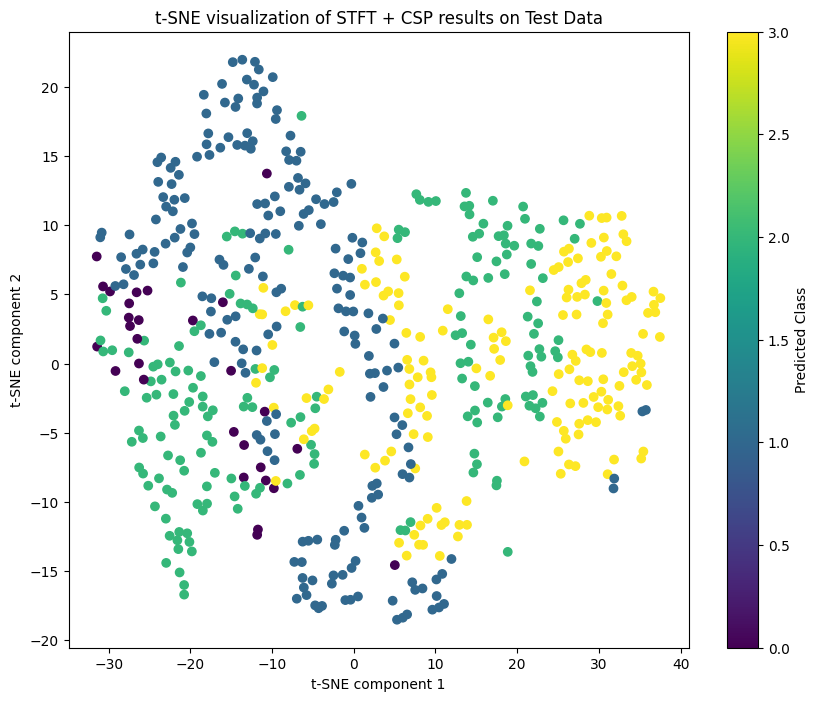

In [25]:
# t-SNE 적용
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_test_csp_flat)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test_pred, cmap='viridis')
plt.title('t-SNE visualization of STFT + CSP results on Test Data')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='Predicted Class')
plt.show()


In [ ]:
import pandas as pd

df = pd.DataFrame({'ID': range(len(test_data_input)), 'Target': y_test_pred})

# CSV 파일을 Kaggle 데이터셋으로 저장
df.to_csv('/kaggle/working/STFT_CSP_LDA_8-12.csv', index=False)